**RAG Project**
25/03/2024

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

In [1]:
# For the deployment with Gradio
!pip install -q gradio
!pip install wandb -qU
!pip install transformers datasets evaluate rouge_score
!pip install accelerate -U

!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 

### Import PDF Document


In [17]:
# Download PDF file
import os
import requests

# Get PDF document which I imported manually
#pdf_path = "GoodLuck.pdf"
pdf_path = "bitcoin.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  #url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File bitcoin.pdf exists.


In [87]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': 0,
  'page_char_count': 3123,
  'page_word_count': 538,
  'page_sentence_count_raw': 23,
  'page_token_count': 780.75,
  'text': "Bitcoin: A Peer-to-Peer Electronic Cash System Satoshi Nakamoto satoshin@gmx.com www.bitcoin.org Abstract.  A purely peer-to-peer version of electronic cash would allow online  payments to be sent directly from one party to another without going through a  financial institution.  Digital signatures provide part of the solution, but the main  benefits are lost if a trusted third party is still required to prevent double-spending.  We propose a solution to the double-spending problem using a peer-to-peer network.  The network timestamps transactions by hashing them into an ongoing chain of  hash-based proof-of-work, forming a record that cannot be changed without redoing  the proof-of-work.  The longest chain not only serves as proof of the sequence of  events witnessed, but proof that it came from the largest pool of CPU power.  As  long as a

In [88]:
# show random sample of the pages
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 6,
  'page_char_count': 2258,
  'page_word_count': 493,
  'page_sentence_count_raw': 12,
  'page_token_count': 564.5,
  'text': "Given our assumption that p > q, the probability drops exponentially as the number of blocks the  attacker has to catch up with increases.  With the odds against him, if he doesn't make a lucky  lunge forward early on, his chances become vanishingly small as he falls further behind. We now consider how long the recipient of a new transaction needs to wait before being  sufficiently certain the sender can't change the transaction.  We assume the sender is an attacker  who wants to make the recipient believe he paid him for a while, then switch it to pay back to  himself after some time has passed.  The receiver will be alerted when that happens, but the  sender hopes it will be too late. The receiver generates a new key pair and gives the public key to the sender shortly before  signing.  This prevents the sender from preparing a chain of bloc

### Get some stats on the text

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the [`sentence-transformers`](https://www.sbert.net/docs/pretrained_models.html) model [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [89]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,0,3123,538,23,780.75,Bitcoin: A Peer-to-Peer Electronic Cash System...
1,1,2452,463,22,613.00,2. Transactions We define an electronic coin a...
2,2,3120,565,29,780.00,4. Proof-of-Work To implement a distributed ti...
3,3,2796,524,24,699.00,New transaction broadcasts do not necessarily ...
4,4,2311,406,17,577.75,8. Simplified Payment Verification It is possi...


In [91]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,9.00,9.00,9.00,9.00,9.00
mean,4.00,2406.11,443.78,20.22,601.53
std,2.74,636.47,122.03,5.61,159.12
min,0.00,1129.00,165.00,12.00,282.25
25%,2.00,2258.00,406.00,17.00,564.50
50%,4.00,2452.00,475.00,22.00,613.00
75%,6.00,2796.00,524.00,24.00,699.00
max,8.00,3123.00,565.00,29.00,780.75


### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage).

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

In [92]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [93]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 3,
  'page_char_count': 2796,
  'page_word_count': 524,
  'page_sentence_count_raw': 24,
  'page_token_count': 699.0,
  'text': "New transaction broadcasts do not necessarily need to reach all nodes.  As long as they reach  many nodes, they will get into a block before long.  Block broadcasts are also tolerant of dropped  messages.  If a node does not receive a block, it will request it when it receives the next block and  realizes it missed one. 6. Incentive By convention, the first transaction in a block is a special transaction that starts a new coin owned  by the creator of the block.  This adds an incentive for nodes to support the network, and provides  a way to initially distribute coins into circulation, since there is no central authority to issue them.  The steady addition of a constant of amount of new coins is analogous to gold miners expending  resources to add gold to circulation.  In our case, it is CPU time and electricity that is expended. The incentiv

In [94]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/9 [00:00<?, ?it/s]

### Chunking our sentences together

In [95]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/9 [00:00<?, ?it/s]

In [96]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 5,
  'page_char_count': 2646,
  'page_word_count': 475,
  'page_sentence_count_raw': 18,
  'page_token_count': 661.5,
  'text': '10. Privacy The traditional banking model achieves a level of privacy by limiting access to information to the  parties involved and the trusted third party.  The necessity to announce all transactions publicly  precludes this method, but privacy can still be maintained by breaking the flow of information in  another place: by keeping public keys anonymous.  The public can see that someone is sending  an amount to someone else, but without information linking the transaction to anyone.  This is  similar to the level of information released by stock exchanges, where the time and size of  individual trades, the "tape", is made public, but without telling who the parties were. As an additional firewall, a new key pair should be used for each transaction to keep them  from being linked to a common owner.  Some linking is still unavoidable with mu

In [97]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00
mean,4.00,2406.11,443.78,20.22,601.53,17.89,2.22
std,2.74,636.47,122.03,5.61,159.12,6.35,0.67
min,0.00,1129.00,165.00,12.00,282.25,10.00,1.00
25%,2.00,2258.00,406.00,17.00,564.50,12.00,2.00
50%,4.00,2452.00,475.00,22.00,613.00,18.00,2.00
75%,6.00,2796.00,524.00,24.00,699.00,23.00,3.00
max,8.00,3123.00,565.00,29.00,780.75,28.00,3.00


### Splitting each chunk into its own item


In [98]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/9 [00:00<?, ?it/s]

20

In [99]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 5,
  'sentence_chunk': "Even if this is accomplished, it does not throw the system open to arbitrary changes, such as creating value out of thin air or taking money that never belonged to the attacker. Nodes are not going to accept an invalid transaction as payment, and honest nodes will never accept a block containing them. An attacker can only try to change one of his own transactions to take back money he recently spent. The race between the honest chain and an attacker chain can be characterized as a Binomial Random Walk. The success event is the honest chain being extended by one block, increasing its lead by +1, and the failure event is the attacker's chain being extended by one block, reducing the gap by -1. The probability of an attacker catching up from a given deficit is analogous to a Gambler's Ruin problem. Suppose a gambler with unlimited credit starts at a deficit and plays potentially an infinite number of trials to try to reach breakeven. We can calcula

In [100]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,20.00,20.00,20.00,20.00
mean,3.45,1062.75,180.25,265.69
std,2.50,446.44,72.71,111.61
min,0.00,1.00,1.00,0.25
25%,1.75,862.25,151.00,215.56
50%,3.00,1132.00,187.50,283.00
75%,5.25,1328.75,222.50,332.19
max,8.00,1749.00,299.00,437.25


In [101]:
# Show random chunks with under 30 tokens in length
min_token_length = 2
# Vérifier si le nombre de lignes dans le dataframe filtré est inférieur à 5
if len(df[df["chunk_token_count"] <= min_token_length]) < 5:
    print("Le dataframe filtré contient moins de 5 lignes.")
else:
    # Prélever un échantillon aléatoire de 5 lignes
    for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
        print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')


Le dataframe filtré contient moins de 5 lignes.


In [102]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 3,
  'sentence_chunk': "A block header with no transactions would be about 80 bytes. If we suppose blocks are generated every 10 minutes, 80 bytes * 6 * 24 * 365 = 4.2MB per year. With computer systems typically selling with 2GB of RAM as of 2008, and Moore's Law predicting current growth of 1.2GB per year, storage should not be a problem even if the block headers must be kept in memory.4 Block Block Block Header (Block Hash) Prev Hash Nonce Hash01 Hash0 Hash1 Hash2 Hash3 Hash23 Root Hash Hash01 Hash2 Tx3 Hash23 Block Header (Block Hash) Root Hash Transactions Hashed in a Merkle Tree After Pruning Tx0-2 from the Block Prev Hash Nonce Hash3 Tx0 Tx1 Tx2 Tx3",
  'chunk_char_count': 639,
  'chunk_word_count': 117,
  'chunk_token_count': 159.75}]

In [103]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': "Bitcoin: A Peer-to-Peer Electronic Cash System Satoshi Nakamoto satoshin@gmx.com www.bitcoin.org Abstract. A purely peer-to-peer version of electronic cash would allow online payments to be sent directly from one party to another without going through a financial institution. Digital signatures provide part of the solution, but the main benefits are lost if a trusted third party is still required to prevent double-spending. We propose a solution to the double-spending problem using a peer-to-peer network. The network timestamps transactions by hashing them into an ongoing chain of hash-based proof-of-work, forming a record that cannot be changed without redoing the proof-of-work. The longest chain not only serves as proof of the sequence of events witnessed, but proof that it came from the largest pool of CPU power. As long as a majority of CPU power is controlled by nodes that are not cooperating to attack the network, they'll generate the long

### Embedding our text chunks


In [104]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

In [105]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447799e-02 -4.51087346e-03 -4.98481654e-03  6.55444637e-02
 -9.87675134e-03  2.72835009e-02  3.66426669e-02 -3.30220396e-03
  8.50083586e-03  8.24953057e-03 -2.28497051e-02  4.02430259e-02
 -5.75200766e-02  6.33692369e-02  4.43207435e-02 -4.49507199e-02
  1.25284335e-02 -2.52012145e-02 -3.55292484e-02  1.29559236e-02
  8.67022295e-03 -1.92917492e-02  3.55632650e-03  1.89506095e-02
 -1.47128282e-02 -9.39843431e-03  7.64171127e-03  9.62186884e-03
 -5.98929124e-03 -3.90169173e-02 -5.47823943e-02 -5.67457918e-03
  1.11644939e-02  4.08067033e-02  1.76319077e-06  9.15296283e-03
 -8.77259858e-03  2.39383057e-02 -2.32784543e-02  8.04999769e-02
  3.19176316e-02  5.12598688e-03 -1.47708477e-02 -1.62524693e-02
 -6.03213198e-02 -4.35689241e-02  4.51211818e-02 -1.79053899e-02
  2.63367314e-02 -3.47866863e-02 -8.89175665e-03 -5.47674857e-02
 -1.24372598e-02 -2.38606799e-02  8.33496526e-02  5.71242087e-02
  1.13328611e-02 -1.49594182e-02  9.2037

In [106]:
%%time
#Take 0.6 GB
# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 643 ms, sys: 1.46 ms, total: 644 ms
Wall time: 658 ms


In [107]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [108]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 72.8 ms


tensor([[ 0.0352,  0.0555,  0.0273,  ...,  0.0634, -0.0104, -0.0582],
        [ 0.0838,  0.0111,  0.0125,  ...,  0.0260,  0.0205, -0.0418],
        [ 0.0295,  0.1049,  0.0514,  ...,  0.0481,  0.0197, -0.0344],
        ...,
        [-0.0257,  0.0212, -0.0211,  ..., -0.0070,  0.0104, -0.0373],
        [ 0.0148,  0.0490,  0.0314,  ...,  0.0427,  0.0094, -0.0387],
        [ 0.0285,  0.0158,  0.0226,  ...,  0.0481, -0.0139, -0.0174]],
       device='cuda:0')

### Save embeddings to file

In [109]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [110]:
# Libérer la mémoire GPU en supprimant les références
#import torch
#del embedding_model
#torch.cuda.empty_cache()

In [111]:
# Check
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,Bitcoin: A Peer-to-Peer Electronic Cash System...,1229,190,307.25,[ 3.51656489e-02 5.55344559e-02 2.73138396e-...
1,0,Introduction Commerce on the Internet has come...,1492,221,373.00,[ 8.37830976e-02 1.10729206e-02 1.25469463e-...
2,0,"In this paper, we propose a solution to the do...",321,48,80.25,[ 2.95044482e-02 1.04918517e-01 5.14227785e-...
3,1,2. Transactions We define an electronic coin a...,1117,199,279.25,[ 5.45381308e-02 2.52545178e-02 1.16815297e-...
4,1,The only way to confirm the absence of a trans...,1297,227,324.25,[ 5.39177172e-02 8.35573152e-02 4.68916930e-...


### 2. RAG - Search and Answer

In [112]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([19, 768])

In [113]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,Bitcoin: A Peer-to-Peer Electronic Cash System...,1229,190,307.25,"[0.0351656489, 0.0555344559, 0.0273138396, -0...."
1,0,Introduction Commerce on the Internet has come...,1492,221,373.00,"[0.0837830976, 0.0110729206, 0.0125469463, -0...."
2,0,"In this paper, we propose a solution to the do...",321,48,80.25,"[0.0295044482, 0.104918517, 0.0514227785, 0.03..."
3,1,2. Transactions We define an electronic coin a...,1117,199,279.25,"[0.0545381308, 0.0252545178, 0.0116815297, 0.0..."
4,1,The only way to confirm the absence of a trans...,1297,227,324.25,"[0.0539177172, 0.0835573152, 0.046891693, 0.02..."


In [114]:
embeddings[0]

tensor([ 3.5166e-02,  5.5534e-02,  2.7314e-02, -2.5469e-02, -5.5572e-02,
         7.8249e-03,  9.0166e-03,  4.0349e-02,  7.3608e-03,  5.2525e-02,
         8.8787e-02,  5.1970e-02, -1.8099e-03,  3.3416e-02,  5.5590e-02,
        -1.9079e-02,  3.0864e-02,  7.5543e-02,  3.0128e-02, -1.4772e-02,
         4.3097e-02, -3.9994e-02,  7.8223e-03, -2.9180e-02, -2.5022e-02,
        -3.8965e-02,  2.7831e-03,  8.1190e-03, -8.4634e-03, -2.6952e-02,
        -2.4824e-02,  2.3359e-02, -6.9683e-02,  4.9453e-02,  2.1905e-06,
        -1.0915e-02, -3.3110e-02,  4.2676e-02, -1.0512e-01,  1.4924e-02,
        -5.8082e-02, -1.0562e-03,  1.0928e-02,  2.5875e-02, -8.0015e-03,
        -1.7021e-02,  3.2661e-02,  4.6025e-02,  1.1807e-02, -4.9981e-03,
         6.2364e-03, -2.5904e-02,  1.0360e-03, -3.8945e-02,  9.4808e-03,
        -1.3659e-02,  1.2998e-03,  1.4316e-02,  4.8283e-02, -1.2988e-02,
        -9.0793e-03, -1.7031e-04, -9.9864e-03, -1.6589e-02,  6.2352e-02,
         3.0708e-02, -3.4240e-03, -3.0704e-02, -3.5

In [115]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

In [116]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 19 embeddings: 0.00019 seconds.


torch.return_types.topk(
values=tensor([0.0945, 0.0477, 0.0473, 0.0387, 0.0180], device='cuda:0'),
indices=tensor([11,  9,  8, 13, 18], device='cuda:0'))

In [117]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([1900, 768])
Time take to get scores on 1900 embeddings: 0.00201 seconds.


In [118]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [119]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.0945
Text:
8. Simplified Payment Verification It is possible to verify payments without
running a full network node. A user only needs to keep a copy of the block
headers of the longest proof-of-work chain, which he can get by querying network
nodes until he's convinced he has the longest chain, and obtain the Merkle
branch linking the transaction to the block it's timestamped in. He can't check
the transaction for himself, but by linking it to a place in the chain, he can
see that a network node has accepted it, and blocks added after it further
confirm the network has accepted it. As such, the verification is reliable as
long as honest nodes control the network, but is more vulnerable if the network
is overpowered by an attacker. While network nodes can verify transactions for
themselves, the simplified method can be fooled by an attacker's fabricated
transactions for as long as the attacker can continue to overpower the network.
O

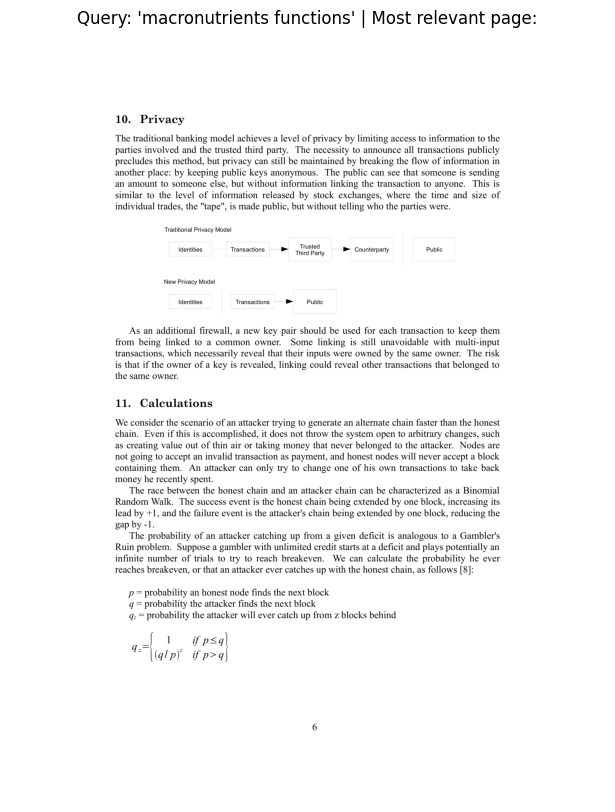

In [120]:
import fitz

# Open PDF and load target page
pdf_path = "bitcoin.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Functionizing our semantic search pipeline

In [121]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [122]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [123]:
#Test

query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 19 embeddings: 0.00008 seconds.
[INFO] Time taken to get scores on 19 embeddings: 0.00008 seconds.
Query: symptoms of pellagra

Results:
Score: 0.0354
⋅{ q/ p z−k if k≤z 1 if kz} Rearranging to avoid summing the infinite tail
of the distribution... 1−∑ k=0 z  k e − k!1−q/ p z−k Converting to C
code... #include <math.h> double AttackerSuccessProbability(double q, int z) {
double p = 1.0 - q;   double lambda = z * (q / p);   double sum = 1.0;   int i,
k;   for (k = 0; k <= z; k++)   {     double poisson = exp(-lambda);     for (i
= 1; i <= k; i++)       poisson *= lambda / i;     sum -= poisson * (1 - pow(q /
p, z - k));   }   return sum; } 7
Page number: 6


Score: -0.0144
In this paper, we propose a solution to the double-spending problem using a
peer-to-peer distributed timestamp server to generate computational proof of the
chronological order of transactions. The system is secure as long as honest
nodes collectively control more CPU po

### LLM

In [58]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [59]:
from huggingface_hub import notebook_login
notebook_login()

In [60]:
# pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 1. Téléchargement et sauvegarde du modèle localement
model_name = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Charger le modèle sur le GPU
model.to("cuda")

# Définir le texte d'entrée
input_text = "Write me a poem about Machine Learning."

# Tokenizer le texte d'entrée
inputs = tokenizer(input_text, return_tensors="pt")

# Déplacer les inputs sur le GPU
inputs = {key: value.to("cuda") for key, value in inputs.items()}

# Générer la sortie à partir du modèle
outputs = model.generate(**inputs)

# Décoder la sortie en texte lisible
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
# Afficher le résultat
print(decoded_output)

tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Write me a poem about Machine Learning.

Machines, they weave and they learn,
From


In [61]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = "google/gemma-2b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# Set use_quantization_config to True or False based on your requirement
use_quantization_config = True
attn_implementation = "sdpa"

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [124]:
# Définir le chemin où sauvegarder le modèle
save_directory = "path/to/gemma2b-llm"

# Sauvegarder le modèle
llm_model.save_pretrained(save_directory)


KeyboardInterrupt: 

In [125]:
# Libérer la mémoire GPU en supprimant les références
del model
torch.cuda.empty_cache()

NameError: name 'model' is not defined

In [66]:
torch.cuda.empty_cache()

In [126]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [127]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106749952, 'model_mem_mb': 2009.15, 'model_mem_gb': 1.96}

### Generating text with our LLM

In [129]:
input_text = "What is proof-of-work ?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is proof-of-work ?

Prompt (formatted):
<bos><start_of_turn>user
What is proof-of-work ?<end_of_turn>
<start_of_turn>model



In [130]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,   9102, 235290,
            559, 235290,   1815,   1654,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,   9102, 235290,
           559, 235290,   1815,   1654,    107,    108,    106,   2516,    108,
           688,  18111, 235290,    559, 235290,   1815,    591,   1975, 235325,
         77056,    603,    476, 212550,  14685,   1671,    575,   3383,  18917,
         65533, 235269,   1582,    685,  29211,    578,  63773, 235269,    577,
         17231,    573,  64260,    578,  24899,    576,    476,  13678,    689,
          6431,    576,   1423, 235265,   1165,    603,    476,  52991,   2185,
           674,   9286,  26149,    476,  30765,   3210,    577,  21830,    573,


In [131]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is proof-of-work ?<end_of_turn>
<start_of_turn>model
**Proof-of-work (PoW)** is a cryptographic algorithm used in certain cryptocurrencies, such as Bitcoin and Ethereum, to verify the authenticity and integrity of a transaction or piece of data. It is a computational process that requires solving a mathematical problem to validate the transaction's validity.

**Here's how it works:**

1. **Data is hashed:** The transaction or data is first converted into a digital "hash." This process creates a unique and irreversible "fingerprint" of the data, known as a hash digest or hash.
2. **Hash is calculated:** The hash is calculated using a specific algorithm, typically a cryptographic hash function, based on the data. This ensures that the same data always produces the same hash, even if the data is modified.
3. **Hash is stored:** The hash is then stored on the blockchain, along with the transaction or data itself. This allows other 

In [132]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is proof-of-work ?

Output text:
**Proof-of-work (PoW)** is a cryptographic algorithm used in certain cryptocurrencies, such as Bitcoin and Ethereum, to verify the authenticity and integrity of a transaction or piece of data. It is a computational process that requires solving a mathematical problem to validate the transaction's validity.

**Here's how it works:**

1. **Data is hashed:** The transaction or data is first converted into a digital "hash." This process creates a unique and irreversible "fingerprint" of the data, known as a hash digest or hash.
2. **Hash is calculated:** The hash is calculated using a specific algorithm, typically a cryptographic hash function, based on the data. This ensures that the same data always produces the same hash, even if the data is modified.
3. **Hash is stored:** The hash is then stored on the blockchain, along with the transaction or data itself. This allows other nodes on the blockchain to verify the transaction's authentici

In [133]:
# Manually created question list
manual_questions = [
    "What is the timestamp server ?"
    "What is the proof-of-work ?"
    "How is the network ?"
]

query_list = manual_questions

In [134]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What is the timestamp server ?What is the proof-of-work ?How is the network ?
[INFO] Time taken to get scores on 19 embeddings: 0.00009 seconds.


(tensor([0.6636, 0.5638, 0.5279, 0.4435, 0.4353], device='cuda:0'),
 tensor([ 5,  2, 18,  0,  4], device='cuda:0'))

### Augmenting our prompt with context items

In [135]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [136]:
  query = random.choice(query_list)
  print(f"Query: {query}")

  # Get relevant resources
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings)

  # Create a list of context items
  context_items = [pages_and_chunks[i] for i in indices]

  # Format prompt with context items
  prompt = prompt_formatter(query=query,
                            context_items=context_items)
  print(prompt)

Query: What is the timestamp server ?What is the proof-of-work ?How is the network ?
[INFO] Time taken to get scores on 19 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin 

In [137]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What is the timestamp server ?What is the proof-of-work ?How is the network ?
RAG answer:
<bos>**Timestamp Server**

The timestamp server is a system that keeps a record of the order in which events happened in a distributed network. This can be used to ensure that a transaction is not double-spent, as the server can be used to verify that the transaction was actually sent first.

**Proof-of-Work**

The proof-of-work is a cryptographic algorithm that is used to ensure that a transaction is sent first. The server generates a hash of the block of data that is being timestamped and then publishes the hash on the network. Any node on the network can then verify the hash and see if the block was sent first.

**Network**

The network is a group of nodes that are all connected to each other. This allows them to share information and collaborate together to keep the network secure. The timestamp server is one of the nodes in the network and is responsible for maintaining the blockchain.

In [138]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [139]:
query = "Quand était la révolution française?"
answer = ask(query=query)
print(answer)


[INFO] Time taken to get scores on 19 embeddings: 0.00007 seconds.
The context does not contain any information about the history of France or when the French Revolution took place. Therefore, I cannot answer this question from the provided context.


In [140]:
query = "Can you describe the role and structure of proteins please ?"
answer = ask(query=query)
print(answer)

[INFO] Time taken to get scores on 19 embeddings: 0.00007 seconds.
The context does not provide any information about the role and structure of proteins, so I cannot answer this query from the provided context.


In [141]:
query = "What is a Peer-to-Peer Electronic Cash System ?"
answer = ask(query=query)
print(answer)

[INFO] Time taken to get scores on 19 embeddings: 0.00009 seconds.
A Peer-to-Peer Electronic Cash System is a purely peer-to-peer version of electronic cash that would allow online payments to be sent directly from one party to another without going through a financial institution. This would eliminate the need for a trusted third party to prevent double-spending.


In [142]:
query = "Timestamp Server ?"
answer = ask(query=query)
print(answer)

[INFO] Time taken to get scores on 19 embeddings: 0.00007 seconds.
The passage describes a proof-of-work system for timestamping data to prevent double-spending. The system involves hashing a block of data and publishing the hash in a public location, such as a newspaper or Usenet post. This ensures that any attempt to change the order of the blocks would be visible to all nodes in the network. Additionally, the system requires a majority of nodes to cooperate to change any block without any trusted third party.


In [143]:
query = "What is the capital of France ?"
answer = ask(query=query)
print(answer)

[INFO] Time taken to get scores on 19 embeddings: 0.00008 seconds.
The context does not provide any information about the capital of France, so I cannot answer this question from the provided context.


In [145]:
query = "What is the problem that Bitcoin aims to solve?"
answer = ask(query=query)
print(answer)

[INFO] Time taken to get scores on 19 embeddings: 0.00008 seconds.
The problem that Bitcoin aims to solve is the double-spending problem, which is a challenge in electronic cash systems where transactions can be easily double-spent. The traditional solution to this problem is to introduce a trusted third party, such as a bank, which checks every transaction to ensure that it is not double-spent. However, this solution is not scalable, as it requires the cooperation of a trusted third party, which could be a potential security risk.


### Deploy our RAG

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from gradio import Interface

# Chargement du modèle T5 pré-entraîné et du tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Définition de la fonction de résumé
def summarize(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
    output = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return summary

# Création de l'interface Gradio
interface = Interface(
    fn=summarize,
    inputs="text",
    outputs="text",
    title="Votre titre",
    description="Votre description."
)

# Lancement de l'interface Gradio
interface.launch()


UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 1970: ordinal not in range(128)